In [1]:
import Tasmanian as ts
import numpy as np
import scipy.optimize as opt
import sys
sys.path.append("..")
from src.py.option import AsianOption


In [2]:
def make_grid(dim, exactness, lb, rb, rule):
    """Creates a sparse grid according to given rules and boundaries.

    Args:
        dim (int): Input Dimension.
        exactness (int): Exactness of the integration.
        lb (array-like): Left boundary. Shape (dim) is recommended.
        rb (array-like): Right boundary. Shape (dim) is recommended.
        rule (str):  One of the local polynomial rules in TASMANIAN docs.
            Defaults to "localp".

    Returns:
        TasmanianSparseGrid: SparseGrid object.
    """
    grid = ts.makeGlobalGrid(
        dim, 1, exactness, "level", rule
    )
    grid.setDomainTransform(np.vstack([lb, rb]).T)
    return grid

aop = AsianOption(d=3)
# iNumInputs = 4
# iNumOutputs = 1
# grid = ts.SparseGrid()
# grid.makeLocalPolynomialGrid(iNumInputs, iNumOutputs, 4, iOrder=1, sRule="localp")


In [3]:
s_0_l=80.0
s_0_r=120.0
sigma_l=0.1
sigma_r=0.2
mu_l=0.02
mu_r=0.05
T_l=0.9
T_r=1.0

transform = np.array(
    [[s_0_l, s_0_r],
    [sigma_l, sigma_r],
    [mu_l, mu_r],
    [T_l, T_r]
    ]
)

In [4]:
dim, level = 3, 2
lb, rb =  np.zeros(dim), np.ones(dim)
grid = make_grid(dim, level, lb, rb, "gauss-patterson")
points = grid.getPoints()


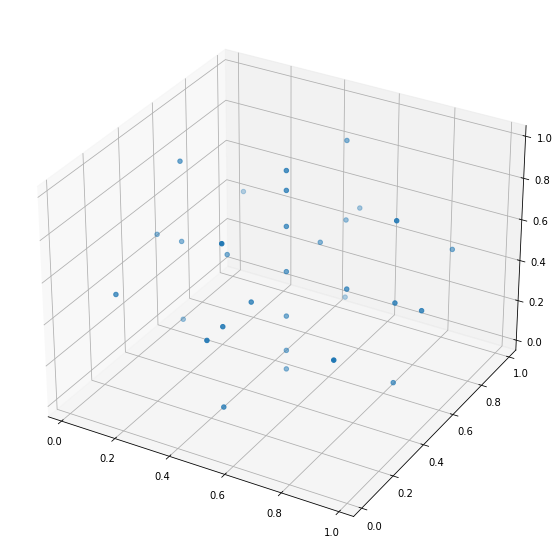

In [5]:
import matplotlib.pyplot as plt

# plt.scatter(points[:, 0], points[:, 1])
# plt.show()
# 3d plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
plt.show()

## Slice Arrays for smoothing

In [6]:
# ar = points[points[:, :-1].argsort(axis=0)[:, 0]]
hyperplanes, indices = np.unique(points[:, :-1], axis=0, return_index=True)

grid_slices = np.split(points, sorted(indices)[1:], axis=0)
grid_slices[0][0, :-1], grid_slices[0][0, -1]

(array([0.5, 0.5]), 0.5)

In [7]:
# def cumargmax(a):
#     m = np.maximum.accumulate(a)
#     x = np.repeat(np.arange(a.shape[0])[:, None], a.shape[1], axis=1)
#     x[1:] *= m[:-1] < m[1:]
#     np.maximum.accumulate(x, axis=0, out=x)
#     return x[:, -1]

# partitions = np.unique(cumargmax(ar))
# grid_slices = np.split(ar, partitions[1:], axis=0)

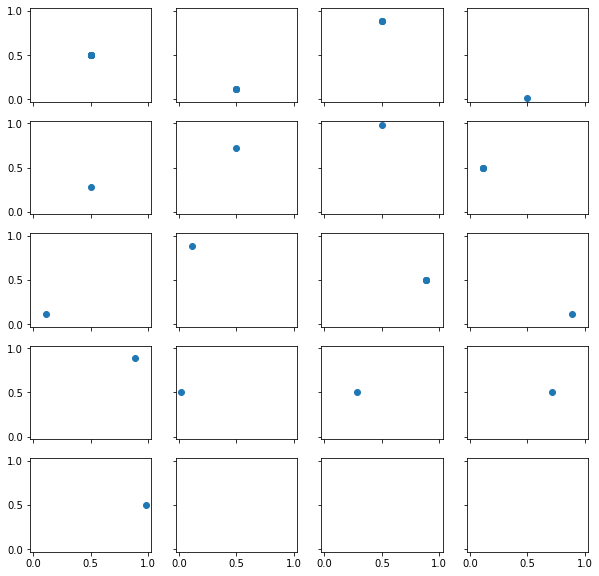

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=4,sharex=True, sharey=True, figsize=(10,10))
axes = np.ravel(axes)
for i in range(len(grid_slices)):
    x, y  = grid_slices[i][:, 0], grid_slices[i][:, 1]
    axes[i].scatter(x,y)
plt.show()

In [9]:
# Nullstellen findung vektorisieren!!!

def payout_coordinate_split(hyperplane, line):
    return aop.payout_func_opt(np.hstack([hyperplane, line]))

def fprime(x):
    return aop.payout_func_opt_der(x, coordinate=-1)

roots = list()
fprime(np.array([0.01975437, 0.5       , 0.5       ]))
for plane in hyperplanes:
    foo = lambda x: aop.payout_func_opt(np.hstack([plane, x]))
    foo_fprime = lambda x: fprime(np.hstack([plane, x]))
    sol = opt.root_scalar(foo, x0=0.99, fprime=foo_fprime, method='newton')
    roots.append(sol.root)


In [14]:
def model(aX):
        # note that the model has to return a 2-D numpy.ndarray
        return np.ones((1,1)) * AsianOption(d=3).payout_func_opt(aX)

S = np.linspace(80, 200, 121)
model(points[-1]).shape

(1, 1)

In [16]:
points[1]

array([0.5       , 0.5       , 0.11270167])

In [11]:
np.inner(grid.getQuadratureWeights(), aop.payout_func_opt(points)), aop.scholes_call()

(8.492760917443741, 8.85622979255249)